Добрый день, жеееесть конечно

План:
- загрузить данные;
- посмотреть и размер, и примеры данных;
- проверить количество пропусков в данных;
    - убедиться, что пропусков в данных нет и можно строить **baseline**;
- разделить данные на train и test;
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже;
- создать baseline модель, получить метрики на тестовой выборке;
- проанализировать данные, подготовить план по очистке и предобработке данных;
- создать функцию очистки;
- произвести очистку train и test выборок -> обучаем модель с очищенными данными;
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение;
- создать класс предобработки данных;
- сделать предобработку очищенных данных -> обучаем модель;
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение;
- И пытаемся увеличить точность

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import random
TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

sns.set_style("darkgrid")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Загрузка

Загружаем данные и проверяем их

In [2]:
# Загрузка данных
df_src = pd.read_csv("boston.csv")

In [3]:
# Размер датасета
df_src.shape

(506, 14)

In [4]:
# Первые 10 строк
df_src.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [5]:
# Проверка пропусков
df_src.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Убедились, что пропусков нет!

# Разделение данных на train и test
Я разделяю данные один раз, чтобы дальнейшие улучшения и предобработка использовали это же разбиение. Зафиксировал сид RANDOM_SEED для воспроизводимости

In [22]:
from sklearn.model_selection import train_test_split

# Признаки и целевая переменная
X = df_src.drop(columns=["MEDV"])
y = df_src["MEDV"]

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

# Проверяю размеры
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

Результат показывает, сколько объектов попало в обучающую и тестовую выборку.
Теперь у меня есть готовая база для построения baseline модели.

# Baseline модель
Создаю простую модель, которая предсказывает для всех объектов тестовой выборки среднее значение MEDV из обучающей выборки.
Так я получаю минимальную точку отсчета

Затем считаю метрики: MAE, RMSE, R², чтобы понять, насколько реально улучшить результат более сложными моделями

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

baseline_pred = [y_train.mean()] * len(y_test)

# Метрики
mae = mean_absolute_error(y_test, baseline_pred)
rmse = mean_squared_error(y_test, baseline_pred) ** 0.5
r2 = r2_score(y_test, baseline_pred)

mae, rmse, r2

(6.255843525529023, 8.662876564628665, -0.023340500652033302)

Видим, что MAE ≈ 6.26, RMSE ≈ 8.66, R² ≈ -0.02
Отправная точка задана, переходим дальше!

# Анализ данных и выявление выбросов
Смотрю на распределение ключевых признаков и их взаимосвязь с целевой переменной MEDV

Особое внимание уделяю признакам LSTAT и RM, так как они сильно коррелируют с ценой домов

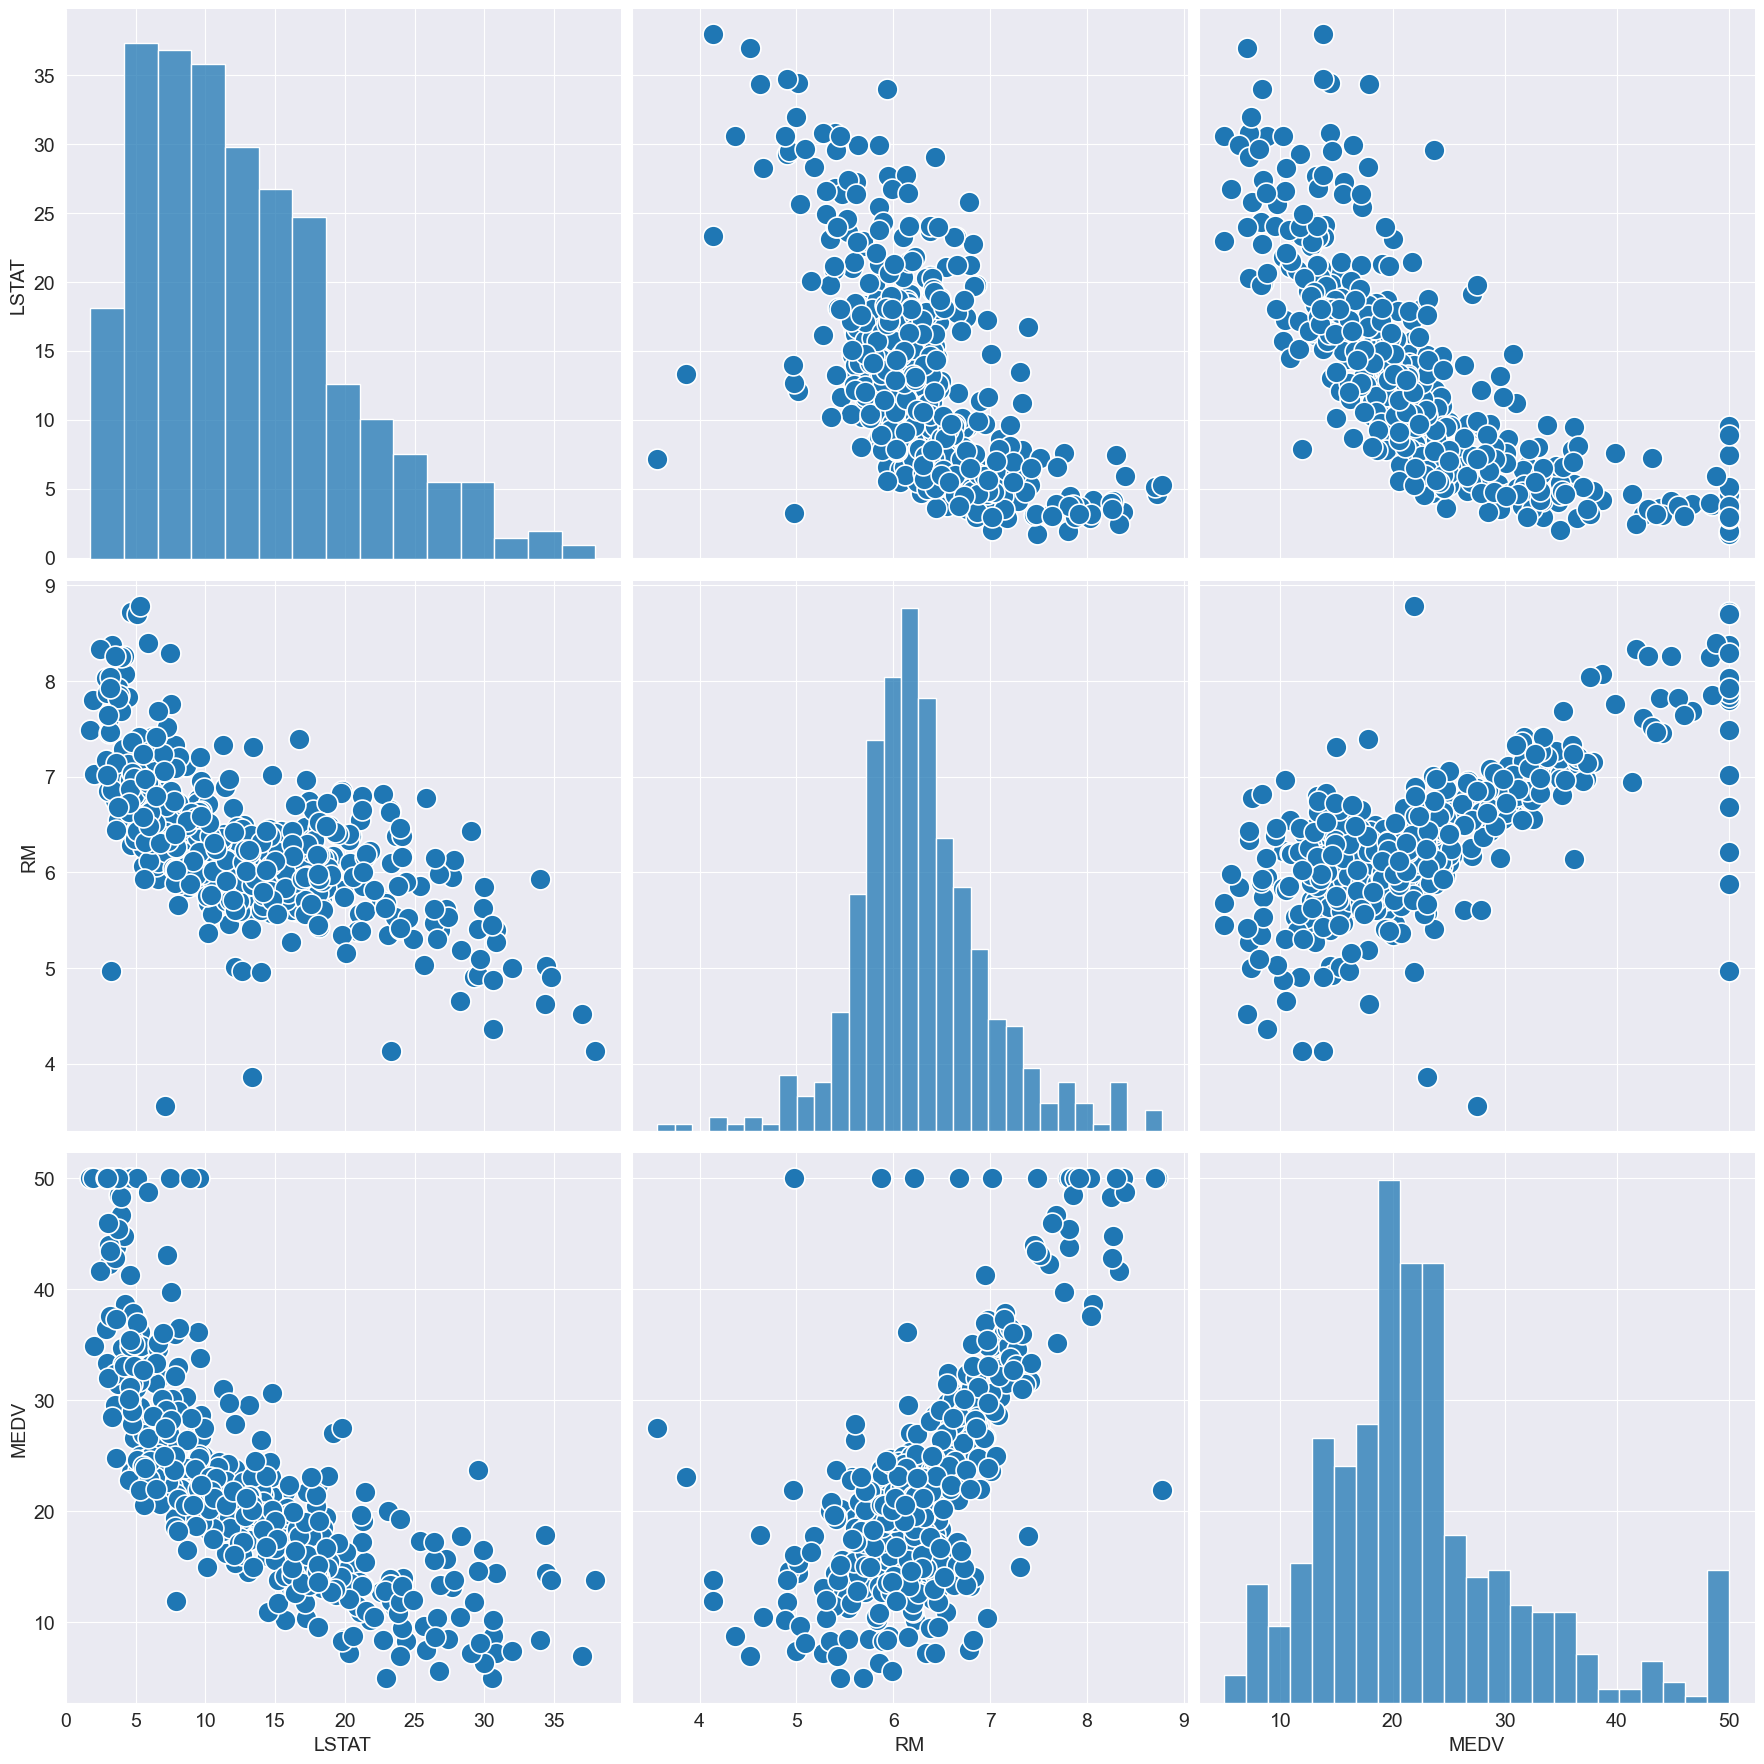

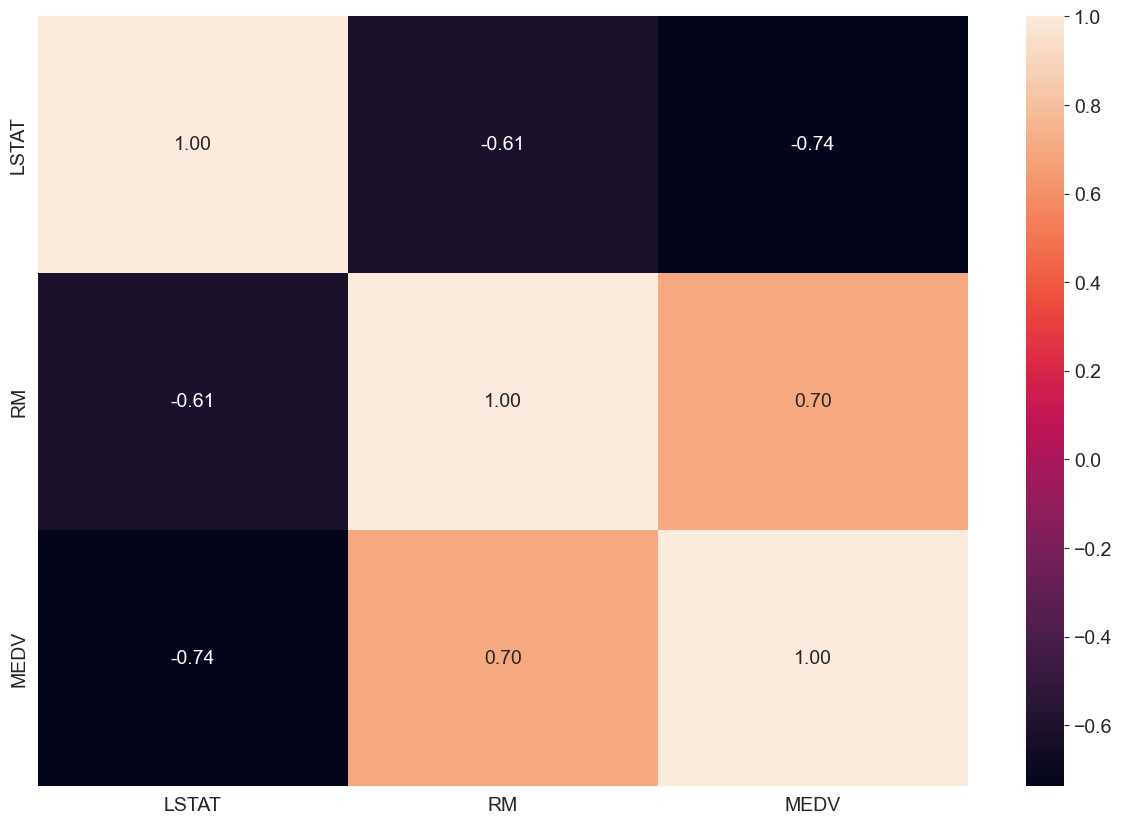

In [24]:
features = ["LSTAT", "RM", "MEDV"]

# Проверка взаимосвязей
sns.pairplot(df_src[features], diag_kind="auto", height=6)
plt.show()

# Проверка корреляции
sns.heatmap(df_src[features].corr(), annot=True, fmt=".2f")
plt.show()

Видим, что:
- LSTAT и MEDV имеют отрицательную зависимость - с ростом LSTAT цена падает
- RM и MEDV положительно связаны, но есть точки, которые явно выбиваются из общей закономерности

Теперь выявляем выбросы

А именно:
- MEDV >= 50 - явно завышенные значения.

- RM < 4 или (RM > 8 & MEDV < 30) - дома с необычным числом комнат относительно цены.

In [25]:
outliers_1 = df_src[df_src["MEDV"] >= 50]
outliers_2 = df_src[(df_src["RM"] < 4) | ((df_src["RM"] > 8) & (df_src["MEDV"] < 30))]

outliers_1
outliers_2

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
364,3.47428,0.0,18.1,1,0.718,8.780,82.9,1.9047,24,666.0,20.2,354.55,5.29,21.9
365,4.55587,0.0,18.1,0,0.718,3.561,87.9,1.6132,24,666.0,20.2,354.70,7.12,27.5
367,13.52220,0.0,18.1,0,0.631,3.863,100.0,1.5106,24,666.0,20.2,131.42,13.33,23.1


Видим, что В outliers_1 много точек с RM < 7 и TAX = 666, это похоже на цензурированную информацию. В outliers_2 находятся необычные дома по количеству комнат.

# Очистка данных
Создам функцию очистки, которая будет удалять явные выбросы из датасета. Это позволит повторно применять очистку на любых выборках (train, test) одинаково.

In [26]:
def clean_data(df):
    outliers_mask_1 = df["MEDV"] >= 50
    outliers_mask_2 = df["RM"] < 4
    outliers_mask_3 = (df["RM"] > 8) & (df["MEDV"] < 30)
    
    outliers_mask = outliers_mask_1 | outliers_mask_2 | outliers_mask_3
    
    return df.loc[~outliers_mask]

In [27]:
# Применяем функцию к исходным данным
df_cleaned = clean_data(df_src)

In [28]:
# Проверка размеров после очистки
df_cleaned.shape

(487, 14)

Размер уменьшился, значит выбросы удалены, проверим, чтобы не было пропусков

In [29]:
df_cleaned.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Пропусков нет!

# Обучение модели
Обучаю модель с очищенными данными, чтобы оценить влияние удаления выбросов на качество предсказаний

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Признаки и целевая переменная для очищенных данных
X_train_clean = X_train.loc[X_train.index.isin(df_cleaned.index)]
y_train_clean = y_train.loc[y_train.index.isin(df_cleaned.index)]

X_test_clean = X_test.loc[X_test.index.isin(df_cleaned.index)]
y_test_clean = y_test.loc[y_test.index.isin(df_cleaned.index)]

# Функция обучения модели
def train_linear_model(X_tr, y_tr):
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    return model

# Обучение модели
cleaned_model = train_linear_model(X_train_clean, y_train_clean)

# Предсказания
y_pred_clean = cleaned_model.predict(X_test_clean)

# Метрики
mae_clean = mean_absolute_error(y_test_clean, y_pred_clean)
rmse_clean = mean_squared_error(y_test_clean, y_pred_clean) ** 0.5
r2_clean = r2_score(y_test_clean, y_pred_clean)

mae_clean, rmse_clean, r2_clean

(2.4865012226064422, 3.574473949250174, 0.7454820054580056)

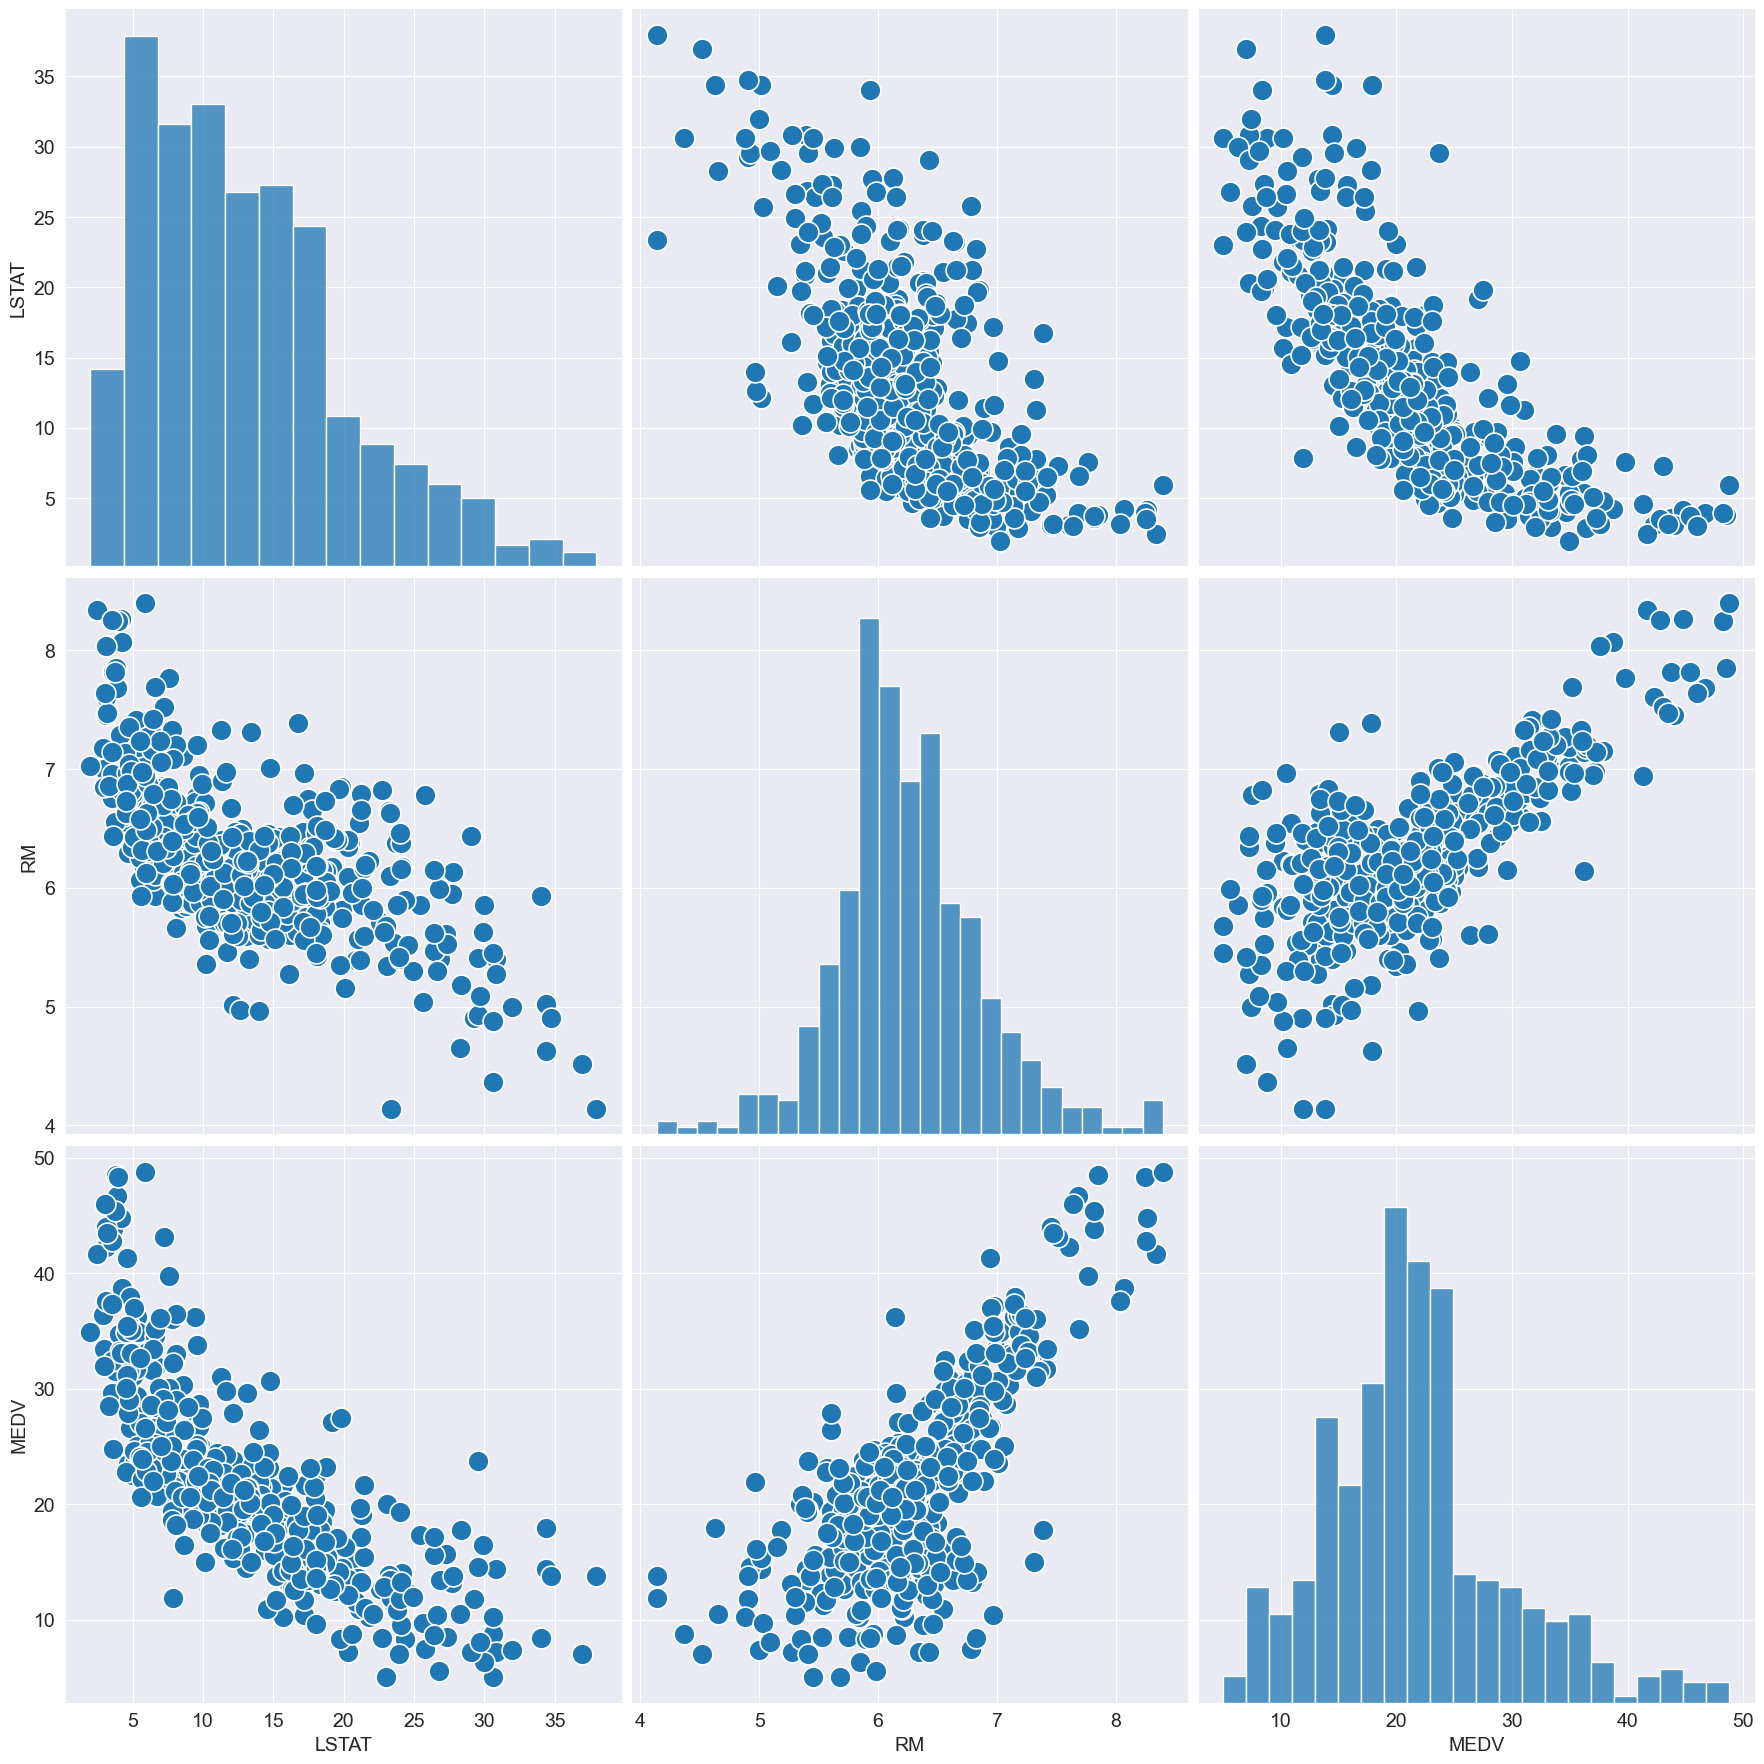

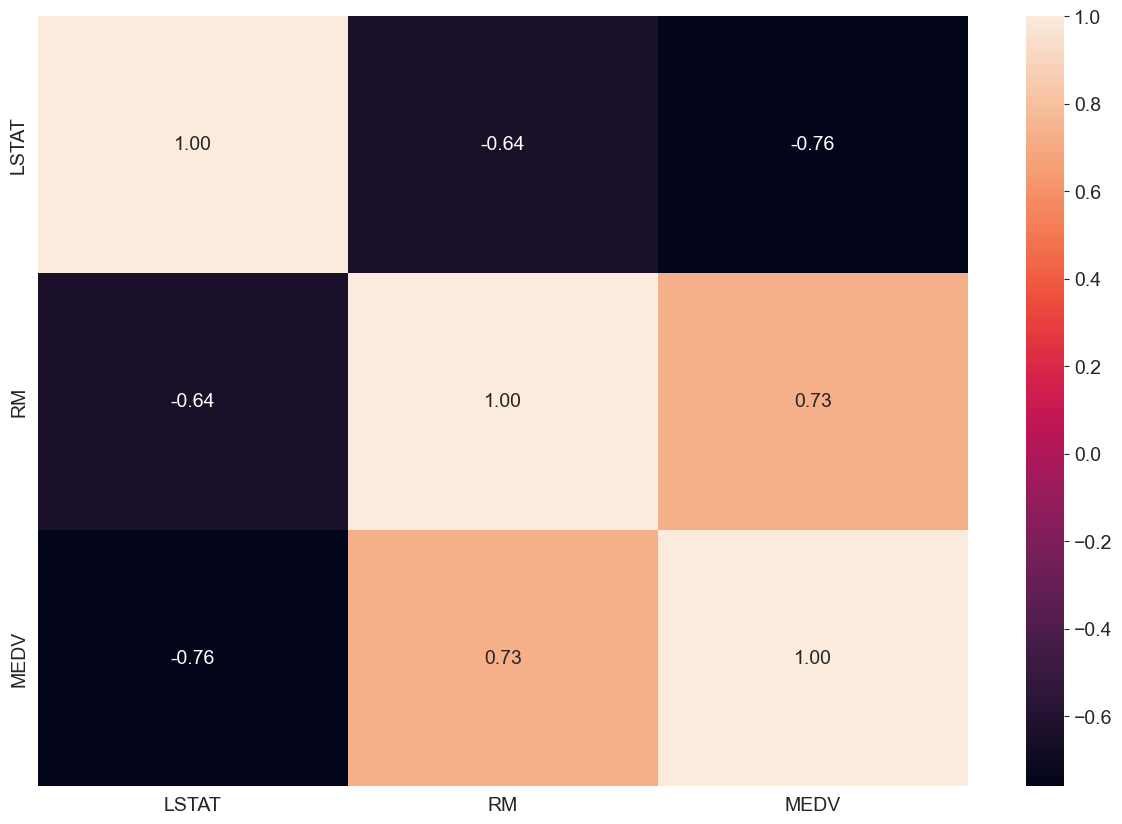

In [35]:
# Проверка взаимосвязей после очистки
features = ["LSTAT", "RM", "MEDV"]
sns.pairplot(df_cleaned[features], diag_kind="auto", height=6)
plt.show()

# Проверка корреляции после очистки
sns.heatmap(df_cleaned[features].corr(), annot=True, fmt=".2f")
plt.show()

Таким образом мы можем видеть, что точность модели выросла 
- RM-MEDV ранее был 0.7, а теперь стал 0.73
- Графики стали чище
- И по метрикам видно большое повышение точности

# Импровизация!
Повышаю точность модели. Для этого создаю новый признак LSTAT_poly_2 для модели. Он равен квадрату LSTAT и может помочь учесть нелинейную зависимость с ценой дома.

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Полиномиальный признак
poly = PolynomialFeatures(degree=2, include_bias=False)
lstat_poly = poly.fit_transform(df_cleaned[["LSTAT"]])
df_cleaned["LSTAT_poly_2"] = lstat_poly[:, 1]

# Разделяем очищенный датасет на train и test
X_cleaned = df_cleaned.drop(columns=["MEDV"])
y_cleaned = df_cleaned["MEDV"]

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=RANDOM_SEED
)

# Обучение модели
model = LinearRegression()
model.fit(X_train_cleaned, y_train_cleaned)

# Предсказания
y_pred_cleaned = model.predict(X_test_cleaned)

# Метрики
mae = mean_absolute_error(y_test_cleaned, y_pred_cleaned)
rmse = mean_squared_error(y_test_cleaned, y_pred_cleaned) ** 0.5
r2 = r2_score(y_test_cleaned, y_pred_cleaned)

mae, rmse, r2

C:\Users\ZZZ\AppData\Local\Temp\ipykernel_11832\671718231.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["LSTAT_poly_2"] = lstat_poly[:, 1]


(2.4920233649593877, 3.3162630405047935, 0.8476426985611251)

Заметно улучшились R² и rmse. Точность выросла